In [2]:
# notebook last tested with abtem version 1.0.0beta7

from abtem import __version__
print('current version:', __version__)

from ase.cluster import Decahedron

import matplotlib.pyplot as plt
from abtem import *
import cupy as cp
from ase import build

from cupy.fft.config import get_plan_cache, show_plan_cache_info
cache = get_plan_cache()
cache.set_size(0)

import dask.array as da
import dask
import os
os.environ["MKL_NUM_THREADS"] = "1"
#os.environ#["MKL_NUM_THREADS"]

current version: 1.0.0beta22


In [2]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster(memory_limit='9gb', n_workers=1)
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\dask_cuda\utils.py:168: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(


In [3]:
from cupy.fft.config import get_plan_cache, show_plan_cache_info
cache = get_plan_cache()
cache.set_size(0)


<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

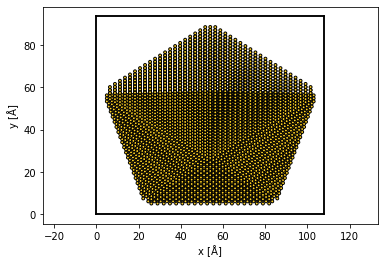

In [4]:
p = 20
q = 3
r = 1

atoms = Decahedron('Au', p, q, r, latticeconstant=None)
atoms.rotate(30, 'x', center='cop')

atoms.center(vacuum=5)

from ase.build import graphene
from abtem.structures import orthogonalize_cell

#atoms = atoms[0:1]

show_atoms(atoms)

In [21]:
len(potential)

34

In [15]:
%%time
fp = FrozenPhonons(atoms, 1, {'Au':.0}, directions='xyz')

potential = Potential(fp, 
                      gpts=1600,
                      device='gpu',
                      projection='infinite', 
                      slice_thickness=.5,
                      chunks=2,
                      precalculate=False)

probe = Probe(energy=100e3, semiangle_cutoff=30, device='gpu')

probe.grid.match(potential)

scan = GridScan((0,0), (potential.extent[0], potential.extent[1]), gpts=(8,7))

waves = probe.multislice(potential, scan, chunks=(11,3))

waves.array

#len(waves)

#detector = PixelatedDetector(max_angle=50, to_cpu=True)

#measurements_4d = probe.scan(scan, detector, potential, chunks=100)

#measurements_4d.array

#measurements_4d = measurements_4d.to_cpu().gaussian_filter(.5)

#measurements_com = measurements_4d.center_of_mass()

Wall time: 15 ms


dask.array<stack, shape=(1, 8, 7, 1600, 1600), dtype=complex64, chunksize=(1, 8, 3, 1600, 1600), chunktype=cupy.ndarray>

In [16]:
11*6

66

In [17]:
%%time
waves.compute(scheduler='single-threaded')

[###############################         ] | 79% Completed |  3.7s3.760056495666504
[#################################       ] | 82% Completed |  8.2s4.480334043502808
[##################################      ] | 86% Completed | 10.5s2.2393546104431152
[########################################] | 100% Completed | 10.6s


OutOfMemoryError: Out of memory allocating 1,146,880,000 bytes (allocated so far: 10,649,602,048 bytes).

In [11]:
measurements_4d.array

,Array,Chunk
Bytes,511.44 MiB,3.74 MiB
Shape,"(119, 115, 101, 97)","(10, 10, 101, 97)"
Count,31474 Tasks,144 Chunks
Type,float32,numpy.ndarray


In [7]:
measurements_4d.array

,Array,Chunk
Bytes,1.98 GiB,14.80 MiB
Shape,"(119, 115, 201, 193)","(10, 10, 201, 193)"
Count,30322 Tasks,144 Chunks
Type,float32,cupy.ndarray


(<AxesSubplot:xlabel='Scattering angle x [mrad]', ylabel='Scattering angle y [mrad]'>,
 <matplotlib.image.AxesImage at 0x19324a22250>)

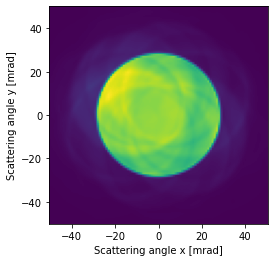

In [12]:
measurements_4d[50,50].show()

In [13]:
measurements_com.compute()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x19324ccf0a0>)

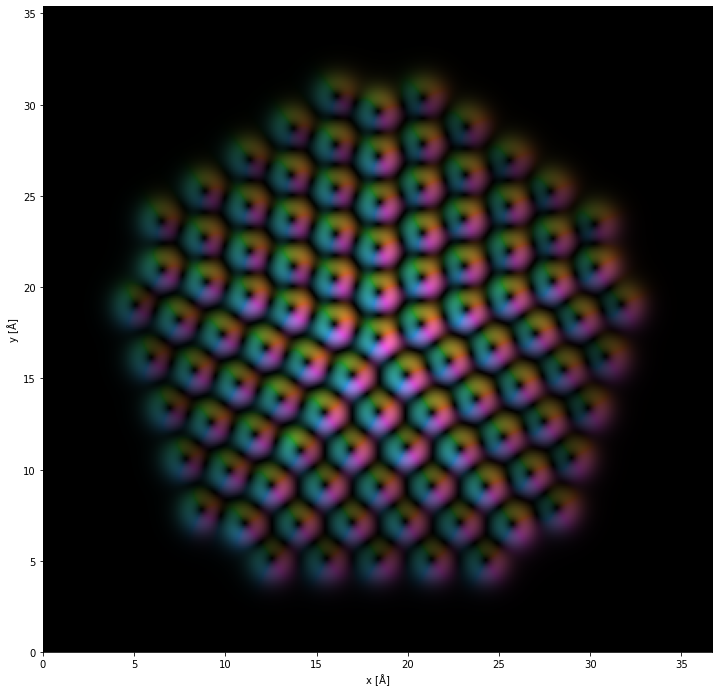

In [17]:
fig,ax =plt.subplots(figsize=(12,12))
measurements_com.interpolate(.1).show(ax)